# Stock Market Trend Prediction with Graph Neural Networks

## Setup and Data Access

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Install Dependencies

In [25]:
!pip install torch_geometric

## Import Libraries

In [26]:
import yfinance as yf
import numpy as np
import pandas as pd
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


## Set Random Seeds for Reproducibility


In [ ]:
import random

RANDOM_SEED = 42

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Fetch S&P 500 Ticker List

In [28]:
import bs4 as bs
import requests
import yfinance as yf
import datetime

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/111.0.0.0 Safari/537.36'
}
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies',headers=headers)
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})
tickers = []
for row in table.findAll('tr')[2:]:
    ticker = row.findAll('td')[1].text
    if ticker.isalpha():
        tickers.append(ticker)

TICKERS = [s.replace('\n', '') for s in tickers]
TICKERS.append("SPY")
START = "2014-01-01"
END   = "2024-12-31"
INTERVAL = "1d"

data_dir = Path("data")
data_dir.mkdir(exist_ok=True)

print(f"Date range: {START} to {END}")
print(f"Interval: {INTERVAL}")

Date range: 2014-01-01 to 2024-12-31
Interval: 1d


## Download Historical Market Data

In [ ]:
def fetch_ticker_df(ticker: str) -> pd.DataFrame:
    """Downloads historical OHLCV data for a stock ticker from Yahoo Finance and formats it for analysis."""
    print(f"  Fetching {ticker}...", end=" ")
    try:
        df = yf.download(
            ticker,
            start=START,
            end=END,
            interval=INTERVAL,
            auto_adjust=False,
            progress=False,
        )

        if isinstance(df.columns, pd.MultiIndex):
          df.columns = df.columns.get_level_values(0)

        df = df.rename(
            columns={
                "Open": "open",
                "High": "high",
                "Low": "low",
                "Close": "close",
                "Adj Close": "adj_close",
                "Volume": "volume",
            }
        )

        df.index.name = "datetime"
        df["ticker"] = ticker
        df = df.reset_index().sort_values("datetime")

        price_cols = ["open", "high", "low", "close", "adj_close", "volume"]
        df = df.dropna(subset=price_cols, how="all")

        print(f"{len(df)} rows")
        return df
    except Exception as e:
        print(f"Error: {e}")
        return pd.DataFrame()


## Load Preprocessed Market Data

In [ ]:
raw_df = pd.read_csv('data/gcn_data.csv')

## Compute Technical Indicators and Features

In [ ]:
raw_df["date"] = pd.to_datetime(raw_df["date"])

print("Computing features...")
for ticker in TICKERS:
    if raw_df[raw_df["ticker"] == ticker].empty:
        if ticker in TICKERS:
            TICKERS.remove(ticker)
        continue
    ticker_df = raw_df[raw_df["ticker"] == ticker].copy().sort_values("date")

    close = ticker_df["close"]
    high = ticker_df["high"]
    low = ticker_df["low"]
    volume = ticker_df["volume"]

    raw_df.loc[raw_df["ticker"] == ticker, "ret_1d"] = close.pct_change(1)
    raw_df.loc[raw_df["ticker"] == ticker, "ret_3d"] = close.pct_change(3)
    raw_df.loc[raw_df["ticker"] == ticker, "ret_5d"] = close.pct_change(5)
    raw_df.loc[raw_df["ticker"] == ticker, "ret_10d"] = close.pct_change(10)

    raw_df.loc[raw_df["ticker"] == ticker, "ma5"] = close.rolling(5).mean()
    raw_df.loc[raw_df["ticker"] == ticker, "ma10"] = close.rolling(10).mean()
    raw_df.loc[raw_df["ticker"] == ticker, "ma20"] = close.rolling(20).mean()

    raw_df.loc[raw_df["ticker"] == ticker, "volatility_10d"] = close.pct_change().rolling(10).std()
    raw_df.loc[raw_df["ticker"] == ticker, "volume_ratio"] = volume / volume.rolling(20).mean()

    raw_df.loc[raw_df["ticker"] == ticker, "ma_cross"] = (
        (raw_df.loc[raw_df["ticker"] == ticker, "ma5"] /
         raw_df.loc[raw_df["ticker"] == ticker, "ma20"]) - 1
    )

    def rsi(series, window=14):
        delta = series.diff()
        gain = np.where(delta > 0, delta, 0.0)
        loss = np.where(delta < 0, -delta, 0.0)
        roll_up = pd.Series(gain).rolling(window).mean()
        roll_down = pd.Series(loss).rolling(window).mean()
        rs = roll_up / roll_down
        rsi_val = 100.0 - (100.0 / (1.0 + rs))
        return pd.Series(rsi_val, index=series.index)

    raw_df.loc[raw_df["ticker"] == ticker, "rsi14"] = rsi(close, window=14).values

    def macd(series, fast=12, slow=26, signal=9):
        ema_fast = series.ewm(span=fast).mean()
        ema_slow = series.ewm(span=slow).mean()
        macd_line = ema_fast - ema_slow
        return macd_line

    raw_df.loc[raw_df["ticker"] == ticker, "macd"] = macd(close).values

raw_df = raw_df.sort_values(["date", "ticker"]).reset_index(drop=True)
print("Features computed!")

Computing features...
Features computed!


## Create Prediction Targets

In [30]:
raw_df = raw_df.sort_values(["ticker", "date"]).reset_index(drop=True)
raw_df = raw_df.drop_duplicates(subset=["date", "ticker"])

print("Computing targets for all tickers (Vectorized)...")

raw_df["next_ret"] = raw_df.groupby("ticker")["ret_1d"].shift(-1)

raw_df["target"] = (raw_df["next_ret"] > 0).astype(int)

target_df = raw_df.pivot(index="date", columns="ticker", values="target")

target_df = target_df.dropna(axis=1)
TICKERS = target_df.columns

print(f"Target Matrix Shape: {target_df.shape}")

Computing targets for all tickers (Vectorized)...
Target Matrix Shape: (2767, 217)


## Build Feature Matrix

In [31]:
feature_cols = ["ret_1d", "ret_3d", "ret_5d", "ret_10d", "ma5", "ma10", "ma20",
                "volatility_10d", "volume_ratio", "ma_cross", "rsi14", "macd"]

pivot_features = {}
for col in feature_cols:
    pivot = raw_df.pivot_table(
        index="date",
        columns="ticker",
        values=col
    )
    pivot_features[col] = pivot

feature_matrix = pd.concat(pivot_features, axis=1)
feature_matrix = feature_matrix.sort_index()

print(f"Feature matrix shape: {feature_matrix.shape}")

Feature matrix shape: (2767, 2531)


## Merge Features and Targets

In [32]:
if isinstance(feature_matrix.columns, pd.MultiIndex):
    feature_matrix.columns = [f"('{col[0]}', '{col[1]}')" for col in feature_matrix.columns]

feature_matrix_reset = feature_matrix.reset_index()
date_col_name = feature_matrix_reset.columns[0]

if date_col_name != "date":
    feature_matrix_reset = feature_matrix_reset.rename(columns={date_col_name: "date"})

feature_matrix_reset["date"] = pd.to_datetime(feature_matrix_reset["date"])

merged_df = feature_matrix_reset.merge(target_df, on="date", how="inner")
merged_df = merged_df.set_index("date").sort_index()

merged_df = merged_df.fillna(0)

print(f"Final dataset shape: {merged_df.shape}")

Final dataset shape: (2767, 2748)


## Prepare Node Features for Graph Construction

In [ ]:
def create_node_features(row):
    """Creates node features for a given date's row in the merged dataframe."""
    features = []
    for ticker in TICKERS:
        ticker_features = []
        for feat in feature_cols:
            col_name = f"('{feat}', '{ticker}')"
            if col_name in row.index:
                ticker_features.append(row[col_name])
            else:
                ticker_features.append(0.0)
        features.append(ticker_features)
    return np.array(features, dtype=np.float32)

all_features = []

for idx, (date, row) in enumerate(merged_df.iterrows()):
    node_features = create_node_features(row)
    all_features.append(node_features)

all_features = np.array(all_features)

scaler = StandardScaler()
n_samples, n_nodes, n_features = all_features.shape

all_features_reshaped = all_features.reshape(-1, n_features)
all_features_reshaped = np.nan_to_num(all_features_reshaped, nan=0.0, posinf=0.0, neginf=0.0)
all_features_scaled = scaler.fit_transform(all_features_reshaped)
all_features_scaled = np.nan_to_num(all_features_scaled, nan=0.0, posinf=0.0, neginf=0.0)
all_features_scaled = all_features_scaled.reshape(n_samples, n_nodes, n_features)

WINDOW_SIZE = 60
CORR_THRESHOLD = 0.25

graph_data_list = []

ret_1d_cols = [f"('ret_1d', '{t}')" for t in TICKERS]

## Build Dynamic Correlation Graphs

In [ ]:
cols_missing = [col for col in ret_1d_cols if col not in feature_matrix.columns]
cols_present = [col for col in ret_1d_cols if col in feature_matrix.columns]

returns_matrix = feature_matrix[cols_present]

print(f"Building dynamic graphs using rolling window of {WINDOW_SIZE} days...")

valid_dates = merged_df.index

for i in range(len(valid_dates)):
    curr_date = valid_dates[i]

    if curr_date not in target_df.index:
        continue

    try:
        date_loc = returns_matrix.index.get_loc(curr_date)
    except KeyError:
        continue

    if date_loc < WINDOW_SIZE:
        continue

    past_returns = returns_matrix.iloc[date_loc-WINDOW_SIZE : date_loc]

    corr_mat = past_returns.corr().values

    edge_index_list = []
    edge_attr_list = []

    TICKERS = corr_mat.shape[0]
    for r in range(len(corr_mat)):
        for c in range(len(corr_mat)):
            if r != c and abs(corr_mat[r, c]) > CORR_THRESHOLD:
                edge_index_list.append([r, c])
                edge_attr_list.append(abs(corr_mat[r, c]))

    if not edge_index_list:
        edge_index = torch.empty((2, 0), dtype=torch.long)
        edge_attr = torch.empty((0,), dtype=torch.float)
    else:
        edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_attr_list, dtype=torch.float)

    daily_features = all_features_scaled[i]
    x = torch.tensor(daily_features, dtype=torch.float)

    daily_targets = target_df.loc[curr_date].values
    y = torch.tensor(daily_targets, dtype=torch.long)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    data.date = curr_date
    graph_data_list.append(data)

Building dynamic graphs using rolling window of 60 days...


## Split Data for Training and Testing

In [35]:
graph_data_list_sorted = sorted(graph_data_list, key=lambda g: g.date)

split_idx = int(0.8 * len(graph_data_list_sorted))
train_data = graph_data_list_sorted[:split_idx]
test_data = graph_data_list_sorted[split_idx:]

print(f"Train samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")

batch_size = 64 if len(train_data) > 5000 else 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

Train samples: 2165
Test samples: 542


## Define Graph Convolutional Network Model

In [ ]:
class PortfolioGCN(nn.Module):
    """Defines a Graph Convolutional Network (GCN) model for stock market trend prediction."""
    def __init__(self, input_dim, hidden_dim=64, output_dim=2):
        super(PortfolioGCN, self).__init__()

        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim // 2)

        self.fc = nn.Linear(hidden_dim // 2, output_dim)

        self.dropout = nn.Dropout(0.4)

    def forward(self, x, edge_index, edge_attr=None, batch=None):
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = self.dropout(x)

        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x = self.dropout(x)

        x = F.relu(self.conv3(x, edge_index, edge_attr))
        x = self.dropout(x)

        out = self.fc(x)

        return out

input_dim = len(feature_cols)
model = PortfolioGCN(input_dim=input_dim, hidden_dim=64, output_dim=2)
print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

PortfolioGCN(
  (conv1): GCNConv(12, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 32)
  (fc): Linear(in_features=32, out_features=2, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)
Total parameters: 7,138


## Train Model to Predict Stock Direction

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

all_train_labels = []
for g in train_data:
    all_train_labels.extend(g.y.numpy())

train_labels_all = np.array(all_train_labels)
class_counts = np.bincount(train_labels_all)
total = len(train_labels_all)
weight_down = total / (2.0 * class_counts[0])
weight_up = total / (2.0 * class_counts[1])
class_weights = torch.tensor([weight_down, weight_up], dtype=torch.float).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights)

def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()

        out = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
        loss = criterion(out, batch.y)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            preds = out.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch.y.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

num_epochs = 80
train_losses = []
train_accs = []
test_accs = []
test_f1s = []
best_test_f1 = 0
best_model_state = None
patience = 15
patience_counter = 0

print("Training...")
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)

    train_preds, train_labels = evaluate(model, train_loader, device)
    test_preds, test_labels = evaluate(model, test_loader, device)

    train_acc = accuracy_score(train_labels, train_preds)
    test_acc = accuracy_score(test_labels, test_preds)
    test_f1 = f1_score(test_labels, test_preds)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    test_f1s.append(test_f1)

    if test_f1 > best_test_f1:
        best_test_f1 = test_f1
        best_model_state = model.state_dict().copy()
        patience_counter = 0
    else:
        patience_counter += 1

    if (epoch + 1) % 1 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} Test Acc: {test_acc:.4f}")

    if patience_counter >= patience:
        print()
        print(f"Early stopping at epoch {epoch+1}")
        break

if best_model_state is not None:
    model.load_state_dict(best_model_state)

print("Training completed!")

Training...
Epoch 1/80
  Train Loss: 0.6945, Train Acc: 0.5720 Test Acc: 0.5774
Epoch 2/80
  Train Loss: 0.6894, Train Acc: 0.5544 Test Acc: 0.5601
Epoch 3/80
  Train Loss: 0.6862, Train Acc: 0.4913 Test Acc: 0.4821
Epoch 4/80
  Train Loss: 0.6836, Train Acc: 0.5061 Test Acc: 0.5090
Epoch 5/80
  Train Loss: 0.6819, Train Acc: 0.4784 Test Acc: 0.4779
Epoch 6/80
  Train Loss: 0.6812, Train Acc: 0.5108 Test Acc: 0.5130
Epoch 7/80
  Train Loss: 0.6803, Train Acc: 0.4795 Test Acc: 0.4766
Epoch 8/80
  Train Loss: 0.6801, Train Acc: 0.4978 Test Acc: 0.4919
Epoch 9/80
  Train Loss: 0.6797, Train Acc: 0.4918 Test Acc: 0.4855
Epoch 10/80
  Train Loss: 0.6796, Train Acc: 0.5308 Test Acc: 0.5220
Epoch 11/80
  Train Loss: 0.6794, Train Acc: 0.5119 Test Acc: 0.5044
Epoch 12/80
  Train Loss: 0.6793, Train Acc: 0.4936 Test Acc: 0.4869
Epoch 13/80
  Train Loss: 0.6791, Train Acc: 0.5496 Test Acc: 0.5377
Epoch 14/80
  Train Loss: 0.6791, Train Acc: 0.5267 Test Acc: 0.5168
Epoch 15/80
  Train Loss: 0.679

## Evaluate Model Performance

In [38]:
test_preds, test_labels = evaluate(model, test_loader, device)

test_acc = accuracy_score(test_labels, test_preds)
test_f1 = f1_score(test_labels, test_preds)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")
print("Classification Report:")
print()
print(classification_report(test_labels, test_preds, target_names=['Down', 'Up']))

Test Accuracy: 0.4890
Test F1-Score: 0.5783
Classification Report:

              precision    recall  f1-score   support

        Down       0.68      0.24      0.35     68588
          Up       0.44      0.84      0.58     49026

    accuracy                           0.49    117614
   macro avg       0.56      0.54      0.46    117614
weighted avg       0.58      0.49      0.45    117614



## Visualize Training Progress

## Training Curves


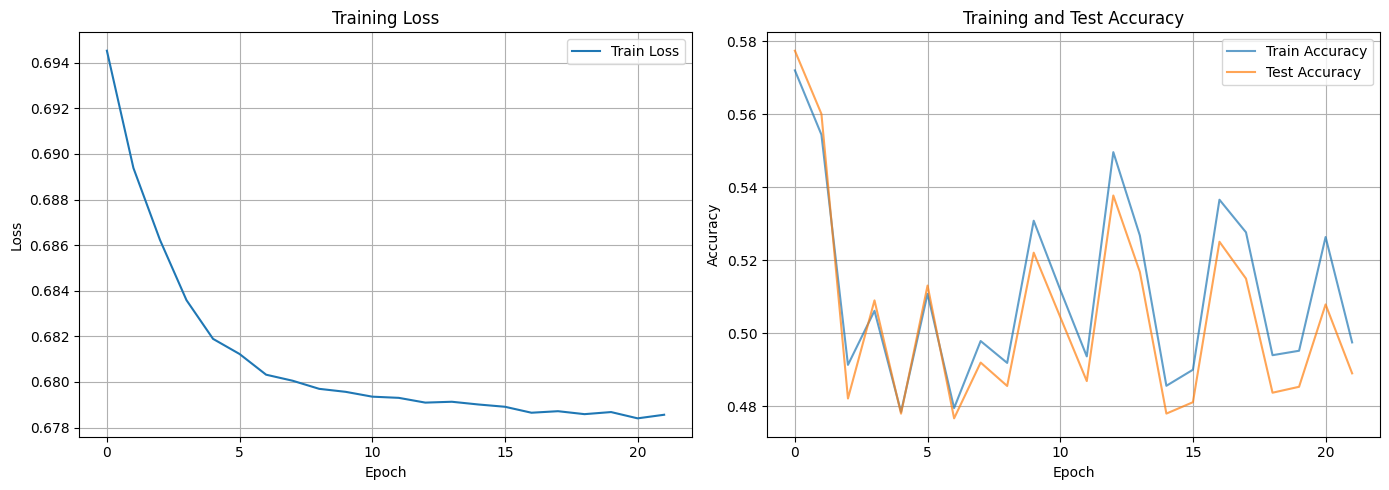

In [ ]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy', alpha=0.7)
plt.plot(test_accs, label='Test Accuracy', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Strategy Backtest

## Backtest Top-K Portfolio Strategy

['WRB', 'DXCM', 'BIO']
['WRB', 'DXCM', 'BIO', 'NXPI', 'IEX']
['WRB', 'DXCM', 'BIO', 'NXPI', 'IEX', 'NVR', 'TDY']
['WRB', 'DXCM', 'BIO', 'NXPI', 'IEX', 'NVR', 'TDY', 'DLR', 'LULU', 'ARE']


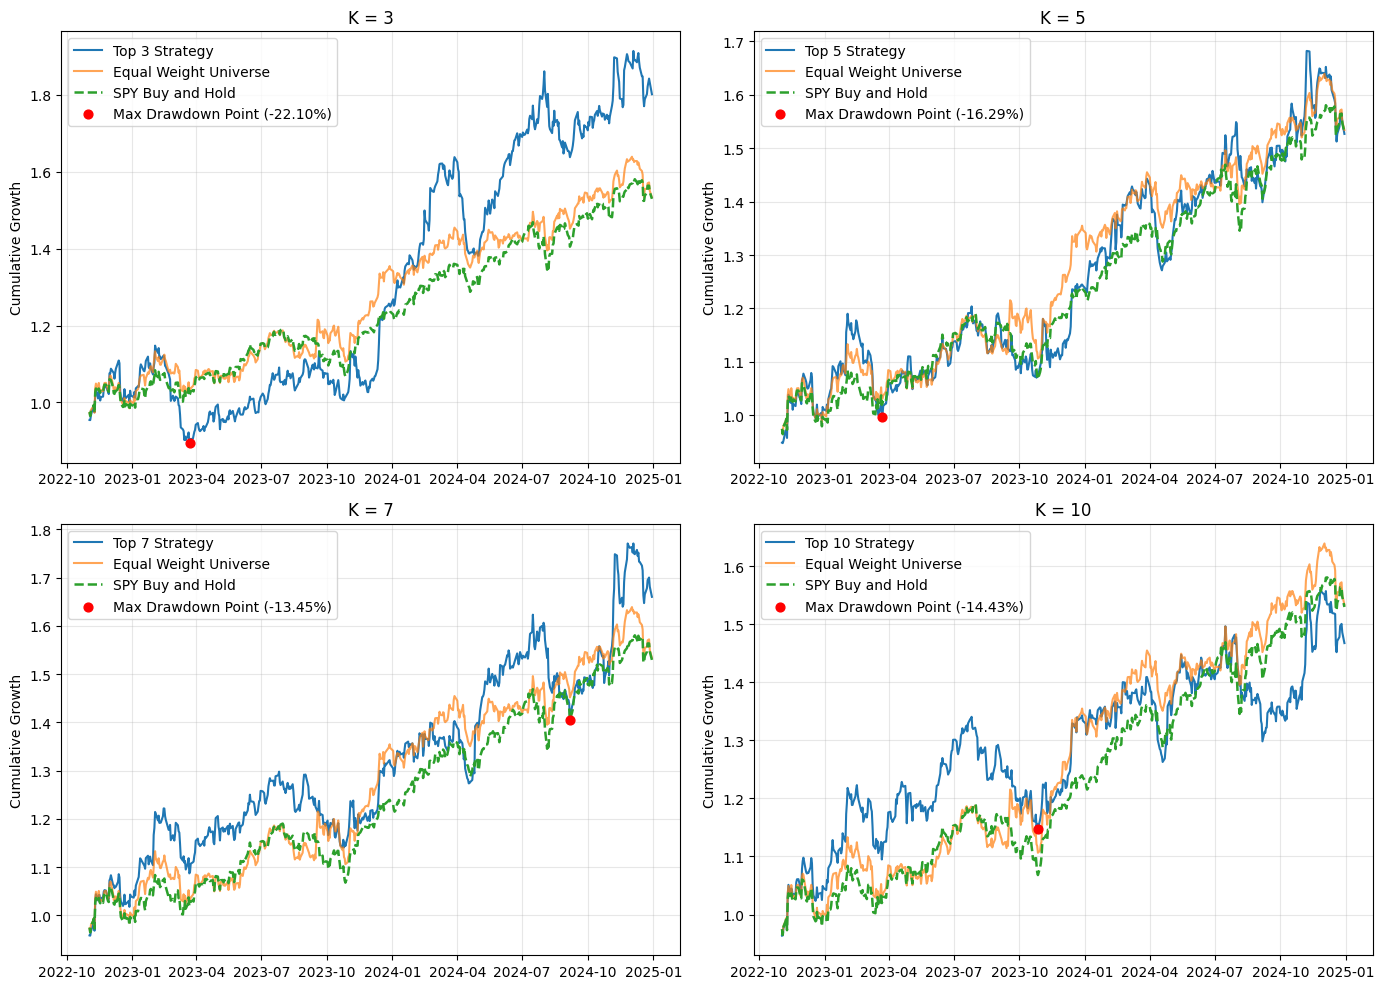

In [40]:
Ks = [3, 5, 7, 10]

spy_test_data = raw_df[raw_df['ticker'] == 'SPY'].set_index('date')
spy_all_dates = spy_test_data.loc[:, 'ret_1d'].fillna(0)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, K in enumerate(Ks):
    portfolio_returns = []
    market_returns = []
    dates = []

    current_idx = split_idx

    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.edge_attr, data.batch)
            probs = F.softmax(out, dim=1)[:, 1]

            num_graphs = data.num_graphs
            nodes_per_graph = corr_mat.shape[0]

            for i in range(num_graphs):
                if current_idx >= len(graph_data_list):
                    break

                start_node = i * nodes_per_graph
                end_node = (i + 1) * nodes_per_graph
                day_probs = probs[start_node:end_node]

                topk_values, topk_indices = torch.topk(day_probs, k=K)
                curr_date = graph_data_list[current_idx].date

                if curr_date in returns_matrix.index:
                    actual_day_rets = returns_matrix.loc[curr_date].values
                    selected_returns = actual_day_rets[topk_indices.cpu().numpy()]
                    port_ret = np.mean(selected_returns)
                    mkt_ret = np.mean(actual_day_rets)

                    portfolio_returns.append(port_ret)
                    market_returns.append(mkt_ret)
                    dates.append(curr_date)

                current_idx += 1

    dates = list(dates)

    strat_cum = (1 + np.array(portfolio_returns)).cumprod()
    mkt_cum = (1 + np.array(market_returns)).cumprod()

    spy_returns = spy_all_dates.loc[dates].values
    spy_cum = (1 + spy_returns).cumprod()

    running_max = np.maximum.accumulate(strat_cum)
    drawdown = (strat_cum - running_max) / running_max * 100
    max_dd = drawdown.min()
    max_dd_idx = drawdown.argmin()

    ax = axes[idx]

    ax.plot(
        dates,
        strat_cum,
        label=f"Top {K} Strategy",
        linewidth=1.5
    )

    ax.plot(
        dates,
        mkt_cum,
        label="Equal Weight Universe",
        alpha=0.7,
        linewidth=1.5
    )

    ax.plot(
        dates,
        spy_cum,
        label="SPY Buy and Hold",
        linewidth=1.8,
        linestyle="--"
    )

    ax.scatter(
        dates[max_dd_idx],
        strat_cum[max_dd_idx],
        color="red",
        s=40,
        zorder=5,
        label=f"Max Drawdown Point ({max_dd:.2f}%)"
    )

    ax.set_title(f"K = {K}")
    ax.set_ylabel("Cumulative Growth")
    ax.grid(alpha=0.3)
    ax.legend()
    selected_tickers = [tickers[j] for j in topk_indices.cpu().numpy()]
    print(selected_tickers)

plt.tight_layout()
plt.show()